In [1]:
import os
import sys
import torch
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))

from model.CNN_model import CNNTextClassifier
from model.BiLSTM_model import BiLSTMModel
from language_model import train, evaluate
from evaluation import class_accuracy, class_f1_score,\
    class_wise_precision_recall, plot_confusion_matrix
from utils import tokenize, remove_stopwords, stemming, fit_tokenizer, plot_loss_acc,\
    pad_sequence, PandasDataset, get_batched_data, get_class_weights

# Data Preparation

In [2]:
data = pd.read_csv("../data/text.csv").drop(columns="Unnamed: 0")
data.sample(10)

,text,label
139769,i know i am not alone when i say i often feel ...,3
210018,i assumed was the precipace of the fire i star...,1
155567,i realized that this random cat on the blue li...,2
162075,i can ask is that you download the book and if...,1
314126,i associate the script with watery pop rock mo...,0
197091,i today so i am feeling very much like belting...,3
284312,i don t want to feel annoyed resentful or angr...,3
68960,im already feeling inspired to write,1
175944,i happen to be one of those new members and i ...,1
94166,i feel exhausted from lack of sleep and have p...,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [4]:
# data.duplicated().sum()
data.drop_duplicates(inplace= True)

### Tokenize, stem and remove stopwords 

In [5]:
data['tokens_stemm'] = data['text'].apply(tokenize).apply(remove_stopwords).apply(stemming)
# data['tokens_stemm'] = data['tokens']
data = data[~(data['tokens_stemm'].apply(len) == 0)]
data.sample(10)

,text,label,tokens_stemm
249343,i appreciate this section because it validates...,0,"[appreci, section, valid, fact, actual, grief,..."
88172,i allow another to garner such control over me...,0,"[allow, anoth, garner, control, loss, life, ma..."
101534,i woke up feeling groggy but there was money i...,0,"[woke, feel, groggi, money, account, went, pay..."
116508,i have the automatic tendency to after being i...,0,"[automat, tendenc, ignor, dump, guy, want, mak..."
68217,i actually feel weird,5,"[actual, feel, weird]"
382934,i am not feeling very creative tonight,1,"[feel, creativ, tonight]"
413842,im feeling quite sympathetic towards poor barry,2,"[im, feel, quit, sympathet, toward, poor, barri]"
99581,i feel that bangs which do not cover the eyes ...,2,"[feel, bang, cover, eye, accept, school]"
155776,i strongly feel that i should be sympathetic t...,2,"[strongli, feel, sympathet, sinc, she, strang,..."
144013,i want to feel welcomed by yes someone else,1,"[want, feel, welcom, ye, someon, els]"


### Split data into train and test sets. Calculate class weights.

In [6]:
# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(data['tokens_stemm'], data['label'], test_size=0.2, random_state=42)
# Calculate class weights
class_weights = get_class_weights(data['label'])
print(f"Class Weights : {class_weights}")

train_data = pd.concat((x_train,y_train), axis=1).reset_index()
test_data = pd.concat((x_test,y_test), axis=1).reset_index()
print(f"Train size: {len(train_data)}\tTest size: {len(test_data)}")

Class Weights : tensor([0.5732, 0.4926, 2.0104, 1.2118, 1.4551, 4.6361])
Train size: 332886	Test size: 83222


### Fit tokenizer

In [7]:
tokenizer = fit_tokenizer(data['tokens_stemm'])
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved to file.")

Tokenizer saved to file.


### Pad the sequences to have uniform length. Batch the data for training.

In [8]:
train_data['padded'] = train_data['tokens_stemm'].apply(pad_sequence, tokenizer= tokenizer)
test_data['padded'] = test_data['tokens_stemm'].apply(pad_sequence, tokenizer= tokenizer)
print("Data prepared for model!")
train_dataset = PandasDataset(train_data)
test_dataset = PandasDataset(test_data)
train_batched = get_batched_data(train_dataset, batch_size= 256)
test_batched = get_batched_data(test_dataset, batch_size= 64)

Data prepared for model!


# CNN

### Initialise the model

In [9]:
model = CNNTextClassifier()
print(model)

CNNTextClassifier(
  (embedding): Embedding(52000, 32)
  (conv): Sequential(
    (0): Conv1d(32, 24, kernel_size=(5,), stride=(1,))
    (1): MaxPool1d(kernel_size=96, stride=96, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (dense): Sequential(
    (0): Linear(in_features=24, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=6, bias=True)
    (3): Softmax(dim=1)
  )
)


In [10]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters: 1668366


### Train the model

In [11]:
model, losses, accs = train(model, train_batched, num_epochs= 6,
                            lr= 0.001, lr_floor= 0.00001,
                            class_weights= class_weights)

  0%|          | 1/976 [00:00<02:16,  7.15it/s]

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
)


  0%|          | 1/976 [00:00<02:32,  6.39it/s]

Epoch 1/6, Iter 1/4 Train Loss: 1.4640, Train Accuracy: 52.525%, Val Accuracy: 79.423%


  0%|          | 1/976 [00:00<02:32,  6.41it/s]

Epoch 1/6, Iter 2/4 Train Loss: 1.3171, Train Accuracy: 68.651%, Val Accuracy: 87.130%


  0%|          | 1/976 [00:00<02:19,  6.98it/s]

Epoch 1/6, Iter 3/4 Train Loss: 1.2566, Train Accuracy: 75.374%, Val Accuracy: 89.441%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 1/6, Iter 4/4 Train Loss: 1.2235, Train Accuracy: 79.071%, Val Accuracy: 90.118%


  0%|          | 1/976 [00:00<02:32,  6.38it/s]

Epoch 2/6, Iter 1/4 Train Loss: 1.1185, Train Accuracy: 90.746%, Val Accuracy: 90.606%


  0%|          | 1/976 [00:00<02:04,  7.84it/s]

Epoch 2/6, Iter 2/4 Train Loss: 1.1168, Train Accuracy: 90.908%, Val Accuracy: 90.924%


  0%|          | 1/976 [00:00<02:44,  5.93it/s]

Epoch 2/6, Iter 3/4 Train Loss: 1.1155, Train Accuracy: 91.016%, Val Accuracy: 91.418%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 2/6, Iter 4/4 Train Loss: 1.1144, Train Accuracy: 91.110%, Val Accuracy: 91.652%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/6, Iter 1/4 Train Loss: 1.1087, Train Accuracy: 91.617%, Val Accuracy: 91.726%


  0%|          | 1/976 [00:00<02:47,  5.83it/s]

Epoch 3/6, Iter 2/4 Train Loss: 1.1082, Train Accuracy: 91.687%, Val Accuracy: 91.884%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/6, Iter 3/4 Train Loss: 1.1076, Train Accuracy: 91.754%, Val Accuracy: 91.918%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/6, Iter 4/4 Train Loss: 1.1072, Train Accuracy: 91.805%, Val Accuracy: 92.014%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 4/6, Iter 1/4 Train Loss: 1.1043, Train Accuracy: 92.115%, Val Accuracy: 92.096%


  0%|          | 1/976 [00:00<02:55,  5.55it/s]

Epoch 4/6, Iter 2/4 Train Loss: 1.1040, Train Accuracy: 92.134%, Val Accuracy: 92.247%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 4/6, Iter 3/4 Train Loss: 1.1038, Train Accuracy: 92.173%, Val Accuracy: 92.149%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 4/6, Iter 4/4 Train Loss: 1.1035, Train Accuracy: 92.201%, Val Accuracy: 92.371%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 5/6, Iter 1/4 Train Loss: 1.1016, Train Accuracy: 92.434%, Val Accuracy: 92.182%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 5/6, Iter 2/4 Train Loss: 1.1016, Train Accuracy: 92.423%, Val Accuracy: 92.327%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 5/6, Iter 3/4 Train Loss: 1.1015, Train Accuracy: 92.422%, Val Accuracy: 92.597%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 5/6, Iter 4/4 Train Loss: 1.1014, Train Accuracy: 92.431%, Val Accuracy: 92.620%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 6/6, Iter 1/4 Train Loss: 1.1010, Train Accuracy: 92.515%, Val Accuracy: 92.536%


  0%|          | 1/976 [00:00<02:31,  6.45it/s]

Epoch 6/6, Iter 2/4 Train Loss: 1.1009, Train Accuracy: 92.516%, Val Accuracy: 92.649%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 6/6, Iter 3/4 Train Loss: 1.1007, Train Accuracy: 92.528%, Val Accuracy: 92.570%


100%|██████████| 976/976 [02:54<00:00,  5.58it/s]


Epoch 6/6, Iter 4/4 Train Loss: 1.1005, Train Accuracy: 92.547%, Val Accuracy: 92.437%


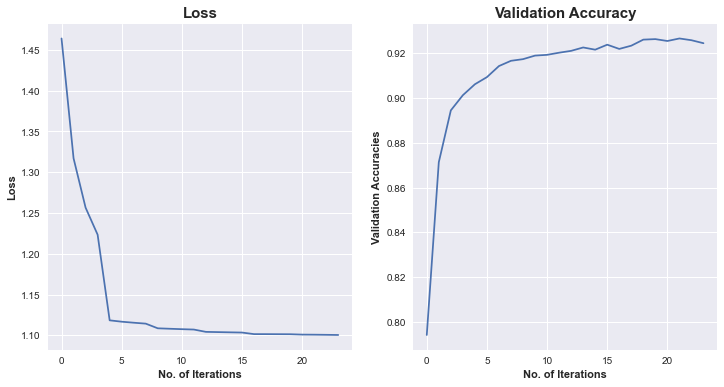

In [13]:
# plot_loss_acc(loss= losses, accs= accs, modelname= 'cnn', plot= False)
plot_loss_acc(loss= losses, accs= accs, modelname= 'cnn', plot= True)

  0%|          | 2/1301 [00:00<01:22, 15.77it/s]

-----------------------------------Evaluating model on test data------------------------------------


100%|██████████| 1301/1301 [00:35<00:00, 36.96it/s]


Average acccuracy: 85.69%
Average F1: 88.38%


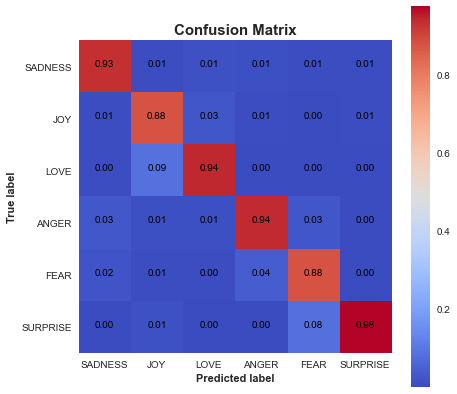

In [14]:
conf_mat = evaluate(model, test_batched)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'cnn', plot= True)

In [15]:
accuracies = class_accuracy(conf_mat)
f1_scores = class_f1_score(conf_mat)
precisions, recalls = class_wise_precision_recall(conf_mat)

average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print(f"Average acccuracy: {average_accuracy*100:.2f}%")
print(f"Average F1: {average_f1*100:.2f}%")

output_df = pd.DataFrame({"Emotion":['Sadness','Joy','Love','Anger','Fear','Surprise'],
                            'Accuracy':accuracies, 'F1_Score':f1_scores,
                            'Precision':precisions, 'Recall':recalls})
output_df

Average acccuracy: 85.69%
Average F1: 88.38%


,Emotion,Accuracy,F1_Score,Precision,Recall
0,Sadness,0.979012,0.955741,0.933551,0.979012
1,Joy,0.981946,0.927938,0.879562,0.981946
2,Love,0.708812,0.809866,0.944526,0.708812
3,Anger,0.893763,0.915794,0.938940,0.893763
4,Fear,0.874427,0.876206,0.877993,0.874427
5,Surprise,0.703198,0.817275,0.975530,0.703198


In [16]:
torch.save(model, f= "../model/cnn.pth")

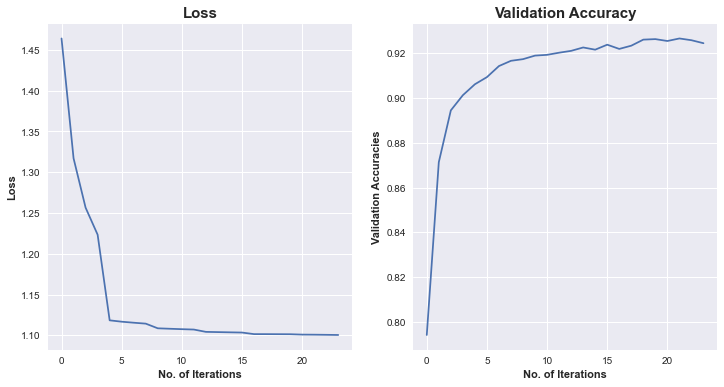

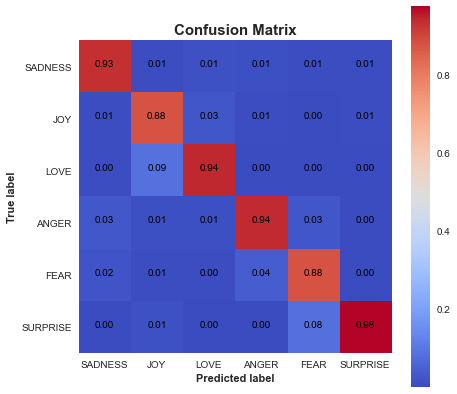

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, AnyStr
from itertools import product

def plot_loss_acc(loss: List, accs: List, modelname: AnyStr, plot = False) -> None:
    plt.style.use("seaborn")
    fig, axes = plt.subplots(1,2, figsize= (12,6))
    num_of_items = len(loss)
    sns.lineplot(ax= axes[0], x= range(num_of_items), y= loss)
    sns.lineplot(ax= axes[1], x= range(num_of_items), y= accs)
    
    axes[0].set_xlabel("No. of Iterations", fontdict={"fontweight":"bold"})
    axes[1].set_xlabel("No. of Iterations", fontdict={"fontweight":"bold"})
    axes[0].set_ylabel("Loss", fontdict={"fontweight":"bold"})
    axes[1].set_ylabel("Validation Accuracies", fontdict={"fontweight":"bold"})
    axes[0].set_title("Loss", fontdict={"fontweight":"bold", "fontsize":15})
    axes[1].set_title("Validation Accuracy", fontdict={"fontweight":"bold", "fontsize":15})
    if plot:
        plt.show()
    else:
        if modelname == 'bilstm':
            fig.savefig(fname= "../images/bilstm_loss_acc.png", dpi=300)
        elif modelname == 'cnn':
            fig.savefig(fname= "../images/cnn_loss_acc.png", dpi=300)

def plot_confusion_matrix(conf_matrix, modelname, plot= False):
    labels = {0: "SADNESS", 1: "JOY", 2: "LOVE", 3: "ANGER", 4: "FEAR", 5: "SURPRISE"}
    plt.style.use("seaborn")
    plt.figure(figsize=(7,7))
    norm_conf_mat = np.divide(conf_matrix, np.sum(conf_matrix, axis= 0))
    plt.imshow(norm_conf_mat, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    
    plt.xticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    plt.yticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    
    fmt = '.2f'
    for i, j in product(range(norm_conf_mat.shape[0]), range(norm_conf_mat.shape[1])):
        plt.text(j, i, format(norm_conf_mat[i, j], fmt),
                 horizontalalignment="center",
                 color="black")
    
    plt.xlabel('Predicted label',fontdict={"fontweight":"bold"})
    plt.ylabel('True label',fontdict={"fontweight":"bold"})
    plt.title('Confusion Matrix',fontdict={"fontsize":15,"fontweight":"bold"})
    plt.grid(False)
    if plot:
        plt.show()
    else:
        if modelname == 'bilstm':
            plt.savefig(fname= "../images/bilstm_confmat.png", dpi=300)
        elif modelname == 'cnn':
            plt.savefig(fname= "../images/cnn_confmat.png", dpi=300)
            
plot_loss_acc(loss= losses, accs= accs, modelname= 'cnn', plot= False)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'cnn', plot= False)

# BiLSTM

### Initialize the model

In [23]:
model = BiLSTMModel()
print(model)

BiLSTMModel(
  (embedding): Embedding(52000, 32)
  (lstm): LSTM(32, 16, bidirectional=True)
  (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (dense): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=6, bias=True)
    (3): Softmax(dim=1)
  )
)


In [24]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters: 1671094


### Train the model

In [25]:
model, losses, accs = train(model, train_batched, num_epochs= 6,
                            lr= 0.0005, lr_floor= 0.000005,
                            class_weights= class_weights)

  0%|          | 0/976 [00:00<?, ?it/s]

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0005
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 1/6, Iter 1/4 Train Loss: 1.7114, Train Accuracy: 22.556%, Val Accuracy: 34.527%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 1/6, Iter 2/4 Train Loss: 1.7936, Train Accuracy: 28.175%, Val Accuracy: 33.909%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 1/6, Iter 3/4 Train Loss: 1.8211, Train Accuracy: 30.053%, Val Accuracy: 33.848%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 1/6, Iter 4/4 Train Loss: 1.8348, Train Accuracy: 31.001%, Val Accuracy: 33.745%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 2/6, Iter 1/4 Train Loss: 1.4049, Train Accuracy: 56.160%, Val Accuracy: 68.405%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 2/6, Iter 2/4 Train Loss: 1.3413, Train Accuracy: 63.004%, Val Accuracy: 75.717%


  0%|          | 1/976 [00:00<03:07,  5.21it/s]

Epoch 2/6, Iter 3/4 Train Loss: 1.2963, Train Accuracy: 68.638%, Val Accuracy: 81.139%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 2/6, Iter 4/4 Train Loss: 1.2685, Train Accuracy: 72.112%, Val Accuracy: 84.229%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/6, Iter 1/4 Train Loss: 1.1959, Train Accuracy: 81.457%, Val Accuracy: 84.825%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/6, Iter 2/4 Train Loss: 1.1800, Train Accuracy: 83.344%, Val Accuracy: 85.274%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/6, Iter 3/4 Train Loss: 1.1724, Train Accuracy: 84.227%, Val Accuracy: 86.563%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/6, Iter 4/4 Train Loss: 1.1672, Train Accuracy: 84.848%, Val Accuracy: 86.704%


  0%|          | 1/976 [00:00<02:52,  5.66it/s]

Epoch 4/6, Iter 1/4 Train Loss: 1.1652, Train Accuracy: 85.164%, Val Accuracy: 87.014%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 4/6, Iter 2/4 Train Loss: 1.1553, Train Accuracy: 86.284%, Val Accuracy: 87.571%


  0%|          | 1/976 [00:00<02:56,  5.53it/s]

Epoch 4/6, Iter 3/4 Train Loss: 1.1510, Train Accuracy: 86.789%, Val Accuracy: 87.778%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 4/6, Iter 4/4 Train Loss: 1.1482, Train Accuracy: 87.111%, Val Accuracy: 87.972%


  0%|          | 1/976 [00:00<02:33,  6.33it/s]

Epoch 5/6, Iter 1/4 Train Loss: 1.1551, Train Accuracy: 86.390%, Val Accuracy: 88.179%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 5/6, Iter 2/4 Train Loss: 1.1461, Train Accuracy: 87.401%, Val Accuracy: 88.377%


  0%|          | 1/976 [00:00<02:50,  5.73it/s]

Epoch 5/6, Iter 3/4 Train Loss: 1.1428, Train Accuracy: 87.785%, Val Accuracy: 88.662%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 5/6, Iter 4/4 Train Loss: 1.1409, Train Accuracy: 88.001%, Val Accuracy: 88.941%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 6/6, Iter 1/4 Train Loss: 1.1509, Train Accuracy: 86.926%, Val Accuracy: 88.513%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 6/6, Iter 2/4 Train Loss: 1.1427, Train Accuracy: 87.830%, Val Accuracy: 88.967%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 6/6, Iter 3/4 Train Loss: 1.1398, Train Accuracy: 88.159%, Val Accuracy: 88.954%


100%|██████████| 976/976 [02:34<00:00,  6.32it/s]


Epoch 6/6, Iter 4/4 Train Loss: 1.1381, Train Accuracy: 88.346%, Val Accuracy: 88.809%


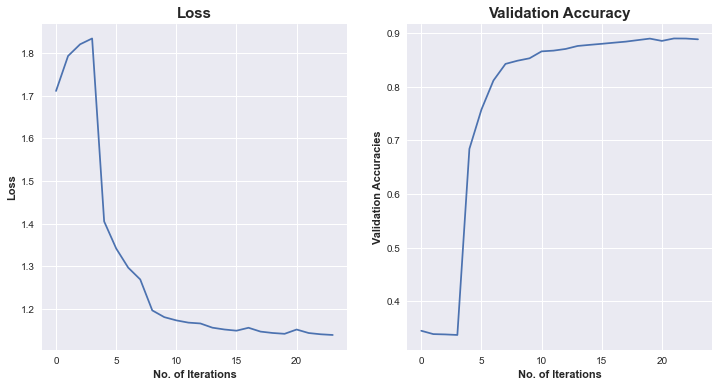

In [29]:
plot_loss_acc(loss= losses, accs= accs, modelname= 'bilstm', plot= True)

  0%|          | 3/1301 [00:00<00:58, 22.31it/s]

-----------------------------------Evaluating model on test data------------------------------------


100%|██████████| 1301/1301 [00:28<00:00, 45.44it/s]


Average acccuracy: 82.22%
Average F1: 85.06%


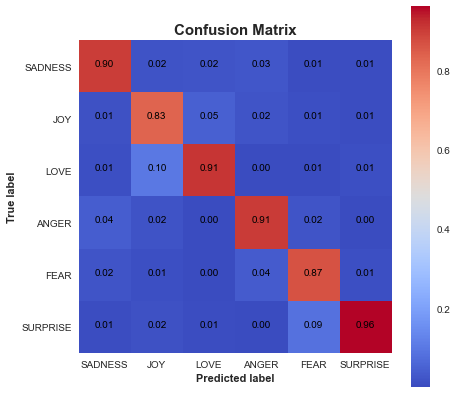

In [30]:
conf_mat = evaluate(model, test_batched)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'bilstm', plot= True)

In [31]:
accuracies = class_accuracy(conf_mat)
f1_scores = class_f1_score(conf_mat)
precisions, recalls = class_wise_precision_recall(conf_mat)

average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print(f"Average acccuracy: {average_accuracy*100:.2f}%")
print(f"Average F1: {average_f1*100:.2f}%")

output_df = pd.DataFrame({"Emotion":['Sadness','Joy','Love','Anger','Fear','Surprise'],
                            'Accuracy':accuracies, 'F1_Score':f1_scores,
                            'Precision':precisions, 'Recall':recalls})
output_df

Average acccuracy: 82.22%
Average F1: 85.06%


,Emotion,Accuracy,F1_Score,Precision,Recall
0,Sadness,0.952146,0.926243,0.901712,0.952146
1,Joy,0.957396,0.891685,0.834415,0.957396
2,Love,0.653899,0.761630,0.911860,0.653899
3,Anger,0.856303,0.880327,0.905738,0.856303
4,Fear,0.853749,0.860742,0.867852,0.853749
5,Surprise,0.659732,0.782747,0.962153,0.659732


In [32]:
torch.save(model,f= "../model/bilstm.pth")

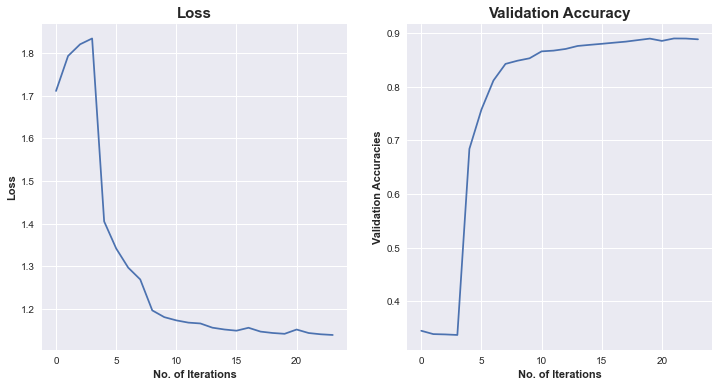

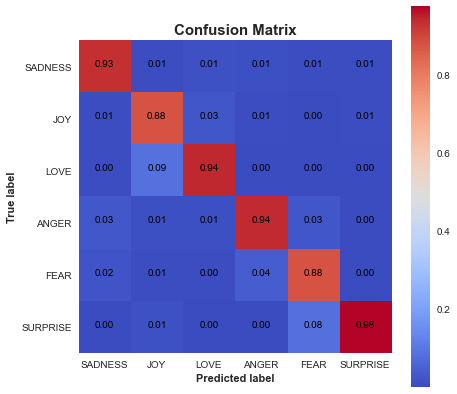

In [28]:
plot_loss_acc(loss= losses, accs= accs, modelname= 'bilstm', plot= False)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'bilstm', plot= False)

# Model Comparison

In [36]:
from tqdm import tqdm
from evaluation import calculate_confusion_matrix

In [37]:
cnn_model = torch.load("../model/cnn.pth")
bilstm_model = torch.load("../model/bilstm.pth")

In [51]:
test_batched_comparison = get_batched_data(test_dataset, batch_size= 512)
len(test_batched_comparison)

163

In [52]:
cnn_accs, bilstm_accs= [], []
for batch in tqdm(test_batched_comparison):
    inputs = batch['padded']
    labels = batch['label']
    cm_cnn = calculate_confusion_matrix(inputs, labels, cnn_model)
    cm_bilstm = calculate_confusion_matrix(inputs, labels, bilstm_model)
    cnn_avg_acc = np.mean(class_accuracy(cm_cnn))
    bilstm_avg_acc = np.mean(class_accuracy(cm_bilstm))
    cnn_accs.append(cnn_avg_acc)
    bilstm_accs.append(bilstm_avg_acc)

100%|██████████| 163/163 [00:27<00:00,  6.02it/s]


(0.0, 163.0)

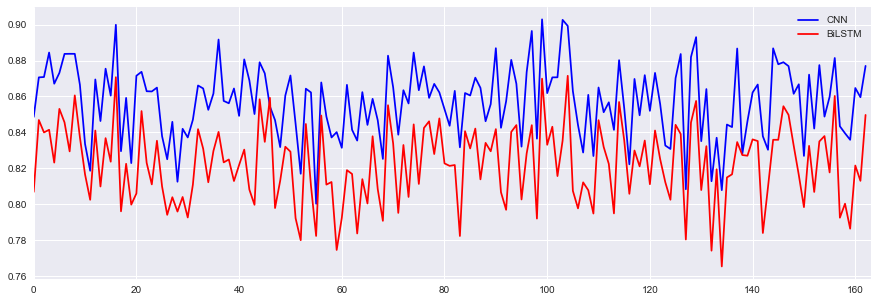

In [57]:
fig, axes = plt.subplots(figsize= (15,5))

sns.lineplot(ax= axes, x= range(len(test_batched_comparison)), y= cnn_accs, color='blue', label= "CNN")
sns.lineplot(ax= axes, x= range(len(test_batched_comparison)), y= bilstm_accs, color='red', label= "Bi-LSTM")
axes.set_xlim(0,163)

In [62]:
print(f"CNN Accuracy - Mean: {np.mean(cnn_accs)*100:.2f}%, Std: {np.std(cnn_accs)*100:.2f}%")
print(f"Bi-LSTM Accuracy - Mean: {np.mean(bilstm_accs)*100:.2f}%, Std: {np.std(bilstm_accs)*100:.2f}%")

CNN Accuracy - Mean: 85.71%, Std: 2.05%
Bi-LSTM Accuracy - Mean: 82.23%, Std: 2.16%


In [70]:
delta = [cnn_accs[i] - bilstm_accs[i] for i in range(len(test_batched_comparison))]
Delta = np.mean(delta)
Var = np.mean([(delta[i]- Delta)**2 for i in range(len(test_batched_comparison))])
print(f"Test Statistic T = {np.round(Delta / np.sqrt(Var),2)}")
print(f"Corresponding p-value (lowest alpha value) = {0.00673}")

Test Statistic T = 2.72
Corresponding p-value (lowest alpha value) = 0.00673


#### This implied that we can say with 99.98% confidence, the CNN model performs better than the Bi-LSTM model